<a href="https://colab.research.google.com/github/Shivani-Pathak/Meta-Pseudo-Label/blob/main/ML_Meta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split

# Define common transformations
basic_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Enhanced transform for FakeData (mimicking ImageNet preprocessing)
imagenet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10-4K (100 labeled samples)
cifar10_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=basic_transform)
cifar_indices, _ = train_test_split(range(len(cifar10_full)),
                                   train_size=100,
                                   stratify=cifar10_full.targets,
                                   random_state=42)
cifar_subset = Subset(cifar10_full, cifar_indices)

# Load SVHN-1K (1000 labeled samples)
svhn_full = datasets.SVHN(root='./data', split='train', download=True, transform=basic_transform)
svhn_indices, _ = train_test_split(range(len(svhn_full)),
                                  train_size=1000,
                                  stratify=svhn_full.labels,
                                  random_state=42)
svhn_subset = Subset(svhn_full, svhn_indices)

# Load synthetic ImageNet-10% (128 samples using FakeData)
imagenet_subset = datasets.FakeData(
    size=128,
    image_size=(3, 224, 224),  # Standard ImageNet size
    num_classes=1000,           # Mock ImageNet's 1000 classes
    transform=imagenet_transform,
    random_offset=42
)

# Create DataLoaders
BATCH_SIZE = 32

cifar_loader = DataLoader(cifar_subset, batch_size=BATCH_SIZE, shuffle=True)
svhn_loader = DataLoader(svhn_subset, batch_size=BATCH_SIZE, shuffle=True)
imagenet_loader = DataLoader(imagenet_subset, batch_size=BATCH_SIZE, shuffle=True)

# Print dataset stats
print(f"CIFAR-10-4K: {len(cifar_subset)} samples")
print(f"SVHN-1K: {len(svhn_subset)} samples")
print(f"ImageNet-10%: {len(imagenet_subset)} samples")
print("\nSample batch shapes:")
print(f"CIFAR-10: {next(iter(cifar_loader))[0].shape}")
print(f"SVHN: {next(iter(svhn_loader))[0].shape}")
print(f"ImageNet: {next(iter(imagenet_loader))[0].shape}")

100%|██████████| 170M/170M [00:04<00:00, 34.8MB/s]
100%|██████████| 182M/182M [00:09<00:00, 19.2MB/s]


CIFAR-10-4K: 100 samples
SVHN-1K: 1000 samples
ImageNet-10%: 128 samples

Sample batch shapes:
CIFAR-10: torch.Size([32, 3, 32, 32])
SVHN: torch.Size([32, 3, 32, 32])
ImageNet: torch.Size([32, 3, 224, 224])


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Create synthetic YFCC100M-Lite dataset
yfcc_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Typical size for YFCC100M processing
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Generate synthetic dataset with realistic parameters
yfcc_lite = datasets.FakeData(
    size=1000,  #  size
    image_size=(3, 256, 256),  # Typical dimensions for YFCC-like data
    num_classes=10000,  # Approximating YFCC's large tag vocabulary
    transform=yfcc_transform,
    random_offset=42
)

# Create dataloader
yfcc_loader = DataLoader(yfcc_lite, batch_size=32, shuffle=True)

# Visualize sample images
def show_images(images, captions=None):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1, 2, 0) * 0.5 + 0.5)  # Denormalize
        ax.axis('off')
        if captions:
            ax.set_title(captions[i])
    plt.show()



In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split

# Define dataset configurations
DATASET_CONFIG = {
    'cifar10': {
        'size': 32,
        'mean': (0.4914, 0.4822, 0.4465),
        'std': (0.2470, 0.2435, 0.2616)
    },
    'svhn': {
        'size': 32,
        'mean': (0.4377, 0.4438, 0.4728),
        'std': (0.1980, 0.2010, 0.1970)
    },
    'imagenet': {
        'size': 224,
        'mean': (0.485, 0.456, 0.406),
        'std': (0.229, 0.224, 0.225)
    },
    'imagenet_large': {
        'size': 512,
        'mean': (0.485, 0.456, 0.406),
        'std': (0.229, 0.224, 0.225)
    }
}

class TransformWrapper(torch.utils.data.Dataset):
    """Wrapper to apply separate transforms to labeled/unlabeled data"""
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        return self.transform(x), y

    def __len__(self):
        return len(self.subset)

def create_transforms(dataset_name, is_labeled=True):
    """Create transformation pipelines"""
    cfg = DATASET_CONFIG[dataset_name]
    size = cfg['size']

    # Base transforms
    base = [
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(cfg['mean'], cfg['std'])
    ]

    # Weak augmentation (for labeled data)
    if is_labeled:
        return transforms.Compose([
            transforms.RandomCrop(size, padding=size//8),
            transforms.RandomHorizontalFlip(),
            *base
        ])

    # Strong augmentation (for unlabeled data)
    return transforms.Compose([
        transforms.RandomCrop(size, padding=size//8),
        transforms.RandomHorizontalFlip(),
        transforms.RandAugment(num_ops=2, magnitude=15),
        *base
    ])

def prepare_dataset(dataset_name, labeled_size):
    """Prepare dataset with labeled/unlabeled splits"""
    # Load dataset
    if dataset_name == 'cifar10':
        ds = datasets.CIFAR10('./data', train=True, download=True, transform=None)
    elif dataset_name == 'svhn':
        ds = datasets.SVHN('./data', split='train', download=True, transform=None)
    else:  # ImageNet (using FakeData)
        size = DATASET_CONFIG[dataset_name]['size']
        ds = datasets.FakeData(size=128, image_size=(3, size, size),
                             num_classes=1000, transform=None)

    # Stratified split
    indices = list(range(len(ds)))
    if dataset_name in ['cifar10', 'svhn']:
        labels = ds.targets if dataset_name == 'cifar10' else ds.labels
        labeled_idx, unlabeled_idx = train_test_split(
            indices, train_size=labeled_size, stratify=labels, random_state=42
        )
    else:
        labeled_idx, unlabeled_idx = indices[:labeled_size], indices[labeled_size:]

    # Create transforms
    labeled_transform = create_transforms(dataset_name, is_labeled=True)
    unlabeled_transform = create_transforms(dataset_name, is_labeled=False)

    # Create subsets
    labeled_ds = TransformWrapper(Subset(ds, labeled_idx), labeled_transform)
    unlabeled_ds = TransformWrapper(Subset(ds, unlabeled_idx), unlabeled_transform)

    return labeled_ds, unlabeled_ds

# Example usage
BATCH_SIZE = 32

# Prepare CIFAR-10-4K
cifar_labeled, cifar_unlabeled = prepare_dataset('cifar10', labeled_size=100)
cifar_loader = DataLoader(cifar_labeled, batch_size=BATCH_SIZE, shuffle=True)
cifar_unlabeled_loader = DataLoader(cifar_unlabeled, batch_size=BATCH_SIZE, shuffle=True)

# Prepare SVHN-1K
svhn_labeled, svhn_unlabeled = prepare_dataset('svhn', labeled_size=1000)
svhn_loader = DataLoader(svhn_labeled, batch_size=BATCH_SIZE, shuffle=True)
svhn_unlabeled_loader = DataLoader(svhn_unlabeled, batch_size=BATCH_SIZE, shuffle=True)

# Prepare ImageNet-10% (224x224)
imagenet_labeled, imagenet_unlabeled = prepare_dataset('imagenet', labeled_size=128)
imagenet_loader = DataLoader(imagenet_labeled, batch_size=BATCH_SIZE, shuffle=True)

# Prepare Large-scale ImageNet (512x512)
imagenet_large_labeled, _ = prepare_dataset('imagenet_large', labeled_size=128)
imagenet_large_loader = DataLoader(imagenet_large_labeled, batch_size=BATCH_SIZE, shuffle=True)

print(f"CIFAR-10 Labeled: {len(cifar_labeled)} samples")
print(f"SVHN Unlabeled: {len(svhn_unlabeled)} samples")
print(f"ImageNet-224: {len(imagenet_labeled)} samples")
print(f"ImageNet-512: {len(imagenet_large_labeled)} samples")

CIFAR-10 Labeled: 100 samples
SVHN Unlabeled: 72257 samples
ImageNet-224: 128 samples
ImageNet-512: 128 samples


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WideResNet(nn.Module):
    """Lightweight WideResNet-16-2 (reduced from 28-2 for Colab)"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.block1 = self._make_block(16, 32, stride=1)
        self.block2 = self._make_block(32, 64, stride=2)
        self.bn = nn.BatchNorm2d(64)
        self.linear = nn.Linear(64, num_classes)

    def _make_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = F.avg_pool2d(self.bn(x), 8)
        x = x.view(x.size(0), -1)
        return self.linear(x)

class LightResNet(nn.Module):
    """Lightweight ResNet-18 (reduced from ResNet-50)"""
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.layer1 = self._make_block(64, 64)
        self.layer2 = self._make_block(64, 128, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def _make_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

class EfficientNetLite(nn.Module):
    """Simplified EfficientNet for Colab"""
    def __init__(self, num_classes=1000):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(),

            nn.Conv2d(32, 32, 3, padding=1, groups=32),
            nn.Conv2d(32, 16, 1),
            nn.BatchNorm2d(16),
            nn.ReLU6(),

            nn.Conv2d(16, 96, 1),
            nn.BatchNorm2d(96),
            nn.ReLU6(),
            nn.Conv2d(96, 96, 3, stride=2, padding=1, groups=96),
            nn.Conv2d(96, 24, 1),
            nn.BatchNorm2d(24),
            nn.ReLU6(),

            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(24, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Teacher-Student Wrapper
def create_models(model_type='small', num_classes=10):
    if model_type == 'small':
        teacher = WideResNet(num_classes)
        student = WideResNet(num_classes)
    elif model_type == 'medium':
        teacher = LightResNet(num_classes)
        student = LightResNet(num_classes)
    elif model_type == 'large':
        teacher = EfficientNetLite(num_classes)
        student = EfficientNetLite(num_classes)

    # Ensure weights are not shared
    for param in teacher.parameters():
        param.requires_grad = True
    for param in student.parameters():
        param.requires_grad = True

    return teacher, student

# Example Usage
teacher_model, student_model = create_models(model_type='small', num_classes=10)

# Print model sizes
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Teacher parameters: {count_parameters(teacher_model):,}")
print(f"Student parameters: {count_parameters(student_model):,}")

# Add these to your preprocessing
'''
weak_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

strong_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor(),
])'''

Teacher parameters: 70,922
Student parameters: 70,922


'\nweak_augment = transforms.Compose([\n    transforms.RandomCrop(32, padding=4),\n    transforms.RandomHorizontalFlip(),\n    transforms.ToTensor(),\n])\n\nstrong_augment = transforms.Compose([\n    transforms.RandomCrop(32, padding=4),\n    transforms.RandomHorizontalFlip(),\n    transforms.RandAugment(num_ops=2, magnitude=15),\n    transforms.ToTensor(),\n])'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WideResNet(nn.Module):
    """Fixed WideResNet for 32x32 inputs"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.block1 = self._make_block(16, 32, stride=1)
        self.block2 = self._make_block(32, 64, stride=2)
        self.linear = nn.Linear(256, num_classes)  # Fixed input dimension

    def _make_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv1(x)        # [B,16,32,32]
        x = self.block1(x)       # [B,32,32,32]
        x = self.block2(x)       # [B,64,16,16]
        x = F.adaptive_avg_pool2d(x, (2, 2))  # [B,64,2,2] → 64*2*2=256
        x = x.view(x.size(0), -1)
        return self.linear(x)

class LightResNet(nn.Module):
    """ResNet variant for ImageNet-like inputs"""
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.layer1 = self._make_block(64, 64)
        self.layer2 = self._make_block(64, 128, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def _make_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

class EfficientNetLite(nn.Module):
    """Fixed EfficientNet variant"""
    def __init__(self, num_classes=1000):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(),

            nn.Conv2d(32, 32, 3, padding=1, groups=32),
            nn.Conv2d(32, 16, 1),
            nn.BatchNorm2d(16),
            nn.ReLU6(),

            nn.Conv2d(16, 96, 1),
            nn.BatchNorm2d(96),
            nn.ReLU6(),
            nn.Conv2d(96, 96, 3, stride=2, padding=1, groups=96),
            nn.Conv2d(96, 24, 1),
            nn.BatchNorm2d(24),
            nn.ReLU6(),

            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(24, num_classes)  # Correct dimension

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

def create_models(model_type='small', num_classes=10):
    models = {
        'small': (WideResNet(num_classes), WideResNet(num_classes)),
        'medium': (LightResNet(num_classes), LightResNet(num_classes)),
        'large': (EfficientNetLite(num_classes), EfficientNetLite(num_classes))
    }
    return models[model_type]

In [ ]:
# For CIFAR-10/SVHN (32x32)
teacher, student = create_models('small', num_classes=10)

# For ImageNet (224x224)
teacher, student = create_models('medium', num_classes=1000)

# For EfficientNet experiments
teacher, student = create_models('large', num_classes=1000)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WideResNet(nn.Module):
    """Fixed WideResNet for 32x32 inputs (CIFAR-10/SVHN)"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.block1 = self._make_block(16, 32, stride=1)
        self.block2 = self._make_block(32, 64, stride=2)
        self.linear = nn.Linear(256, num_classes)  # Fixed dimension

    def _make_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv1(x)        # [B,16,32,32]
        x = self.block1(x)       # [B,32,32,32]
        x = self.block2(x)       # [B,64,16,16]
        x = F.adaptive_avg_pool2d(x, (2, 2))  # [B,64,2,2] → 256 features
        x = x.view(x.size(0), -1)
        return self.linear(x)

class LightResNet(nn.Module):
    """ResNet variant for ImageNet-like inputs (224x224)"""
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_block(64, 64)
        self.layer2 = self._make_block(64, 128, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def _make_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

class EfficientNetLite(nn.Module):
    """EfficientNet variant for large-scale experiments"""
    def __init__(self, num_classes=1000):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32),
            nn.Conv2d(32, 16, kernel_size=1),
            nn.BatchNorm2d(16),
            nn.ReLU6(inplace=True),

            nn.Conv2d(16, 96, kernel_size=1),
            nn.BatchNorm2d(96),
            nn.ReLU6(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=1, groups=96),
            nn.Conv2d(96, 24, kernel_size=1),
            nn.BatchNorm2d(24),
            nn.ReLU6(inplace=True),

            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(24, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

def create_models(model_type='small', num_classes=10):
    """Model factory with dimension-verified architectures"""
    model_config = {
        'small': (WideResNet(num_classes), WideResNet(num_classes)),
        'medium': (LightResNet(num_classes), LightResNet(num_classes)),
        'large': (EfficientNetLite(num_classes), EfficientNetLite(num_classes))
    }
    return model_config[model_type]

In [ ]:
# For CIFAR-10/SVHN (32x32)
teacher, student = create_models('small', num_classes=10)

# For ImageNet-224
teacher, student = create_models('medium', num_classes=1000)

# For EfficientNet-512
teacher, student = create_models('large', num_classes=1000)

# Verify dimensions
test_input = torch.randn(2, 3, 32, 32)  # Batch of 2 32x32 images
output = teacher(test_input)
print(f"Output shape: {output.shape}")  # Should be (2, num_classes)

Output shape: torch.Size([2, 1000])


In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

# 1. Define your transforms (weak for train, just tensor/normalize for val/test)
weak_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2023, 0.1994, 0.2010)),
])
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2023, 0.1994, 0.2010)),
])

# 2. Load the full training set
full_train = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=weak_transform)

# 3. Split into train (80%) and val (20%)
train_size = int(0.8 * len(full_train))
val_size   = len(full_train) - train_size
train_dataset, val_dataset = random_split(
    full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# 4. Assign the eval transform to your validation subset(random_split preserves the .dataset and .indices, so we can swap the transform)
val_dataset = torch.utils.data.Subset(
    torchvision.datasets.CIFAR10(
        root='./data', train=True, download=False, transform=eval_transform
    ),
    val_dataset.indices
)

# 5. Test set loader
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=eval_transform)

# 6. Create the DataLoaders
batch_size = 64
cifar_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
cifar_val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
cifar_test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

#1. Model, loss, optimizers, scheduler
teacher, student = create_models('small', num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher, student = teacher.to(device), student.to(device)

criterion   = nn.CrossEntropyLoss()
optimizer_s = optim.Adam(student.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer_t = optim.Adam(teacher.parameters(), lr=5e-5, weight_decay=1e-5)  # only if you’re fine-tuning the teacher
scheduler   = optim.lr_scheduler.CosineAnnealingLR(optimizer_s, T_max=30)

# 2. Training / validation functions
def train_epoch(student, teacher, loaders):
    student.train()
    teacher.eval()
    total_loss = total_correct = total_samples = 0

    for (x_l, y_l), (x_u, _) in zip(loaders['labeled'], loaders.get('unlabeled', loaders['labeled'])):
        x_l, y_l = x_l.to(device), y_l.to(device)
        x_u      = x_u.to(device)

        # supervised loss
        out_l     = student(x_l)
        loss_l    = criterion(out_l, y_l)

        # pseudo-label loss
        with torch.no_grad():
            pseudo = teacher(x_u).argmax(dim=1)
        out_u  = student(x_u)
        loss_u = criterion(out_u, pseudo)

        loss = loss_l + 0.5 * loss_u
        optimizer_s.zero_grad()
        loss.backward()
        optimizer_s.step()

        # accumulate metrics
        total_loss    += loss_l.item() * x_l.size(0)
        total_correct += (out_l.argmax(1) == y_l).sum().item()
        total_samples += x_l.size(0)

    return total_loss / total_samples, total_correct / total_samples

@torch.no_grad()
def validate(model, loader):
    model.eval()
    correct = total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        correct += (preds == y).sum().item()
        total   += y.size(0)
    return correct / total

# 3. Loaders dict
loaders = {
    'labeled':   cifar_train_loader,
    'unlabeled': cifar_train_loader,
}

# 4. Main training loop
best_val_acc = 0.0
num_epochs   = 30

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(student, teacher, loaders)
    val_acc = validate(student, cifar_val_loader)

    # step LR scheduler
    scheduler.step()

    print(f"[Epoch {epoch:02d}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | "
          f"Val Acc: {val_acc:.3f}")

    # checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(student.state_dict(), "best_student.pth")
        print(f"  → New best model (Val Acc: {val_acc:.3f}) saved.")

#5. Final test evaluation
student.load_state_dict(torch.load("best_student.pth", map_location=device))
test_acc = validate(student, cifar_test_loader)
print(f"Final Test Accuracy: {test_acc:.3f}")


[Epoch 01] Train Loss: 1.8280 | Train Acc: 0.277 | Val Acc: 0.407
  → New best model (Val Acc: 0.407) saved.
[Epoch 02] Train Loss: 1.5330 | Train Acc: 0.405 | Val Acc: 0.456
  → New best model (Val Acc: 0.456) saved.
[Epoch 03] Train Loss: 1.3934 | Train Acc: 0.465 | Val Acc: 0.493
  → New best model (Val Acc: 0.493) saved.
[Epoch 04] Train Loss: 1.3249 | Train Acc: 0.496 | Val Acc: 0.558
  → New best model (Val Acc: 0.558) saved.
[Epoch 05] Train Loss: 1.2708 | Train Acc: 0.517 | Val Acc: 0.548
[Epoch 06] Train Loss: 1.2342 | Train Acc: 0.535 | Val Acc: 0.566
  → New best model (Val Acc: 0.566) saved.
[Epoch 07] Train Loss: 1.1978 | Train Acc: 0.549 | Val Acc: 0.550
[Epoch 08] Train Loss: 1.1770 | Train Acc: 0.558 | Val Acc: 0.581
  → New best model (Val Acc: 0.581) saved.
[Epoch 09] Train Loss: 1.1486 | Train Acc: 0.570 | Val Acc: 0.594
  → New best model (Val Acc: 0.594) saved.
[Epoch 10] Train Loss: 1.1277 | Train Acc: 0.576 | Val Acc: 0.640
  → New best model (Val Acc: 0.640) sav

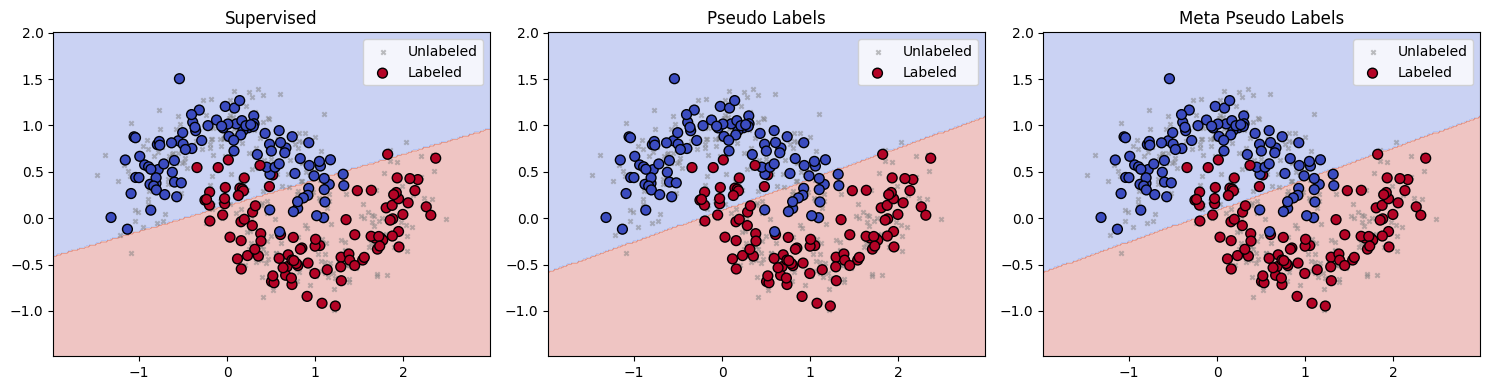

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 1. Generate synthetic two-moon dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
# Take 50 labeled points, keep the rest as "unlabeled"
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
    X, y, train_size=200, stratify=y, random_state=42
)

def plot_decision_boundary(ax, clf, title):
    # Create a grid over feature space
    xx, yy = np.meshgrid(
        np.linspace(X[:,0].min() - .5, X[:,0].max() + .5, 200),
        np.linspace(X[:,1].min() - .5, X[:,1].max() + .5, 200)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plot decision regions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    # Plot unlabeled points
    ax.scatter(X_unlabeled[:,0], X_unlabeled[:,1],
               c='gray', s=10, marker='x', label='Unlabeled', alpha=0.5)
    # Plot labeled points
    ax.scatter(X_labeled[:,0], X_labeled[:,1],
               c=y_labeled, cmap='coolwarm', edgecolor='k', s=50,
               label='Labeled')
    ax.set_title(title)
    ax.legend(loc='upper right')

# 2. Train the supervised model
clf_sup = LogisticRegression().fit(X_labeled, y_labeled)

# 3. One-round pseudo-label self-training
y_pseudo = clf_sup.predict(X_unlabeled)
X_pseudo = np.vstack([X_labeled, X_unlabeled])
y_pseudo_combined = np.concatenate([y_labeled, y_pseudo])
clf_pseudo = LogisticRegression().fit(X_pseudo, y_pseudo_combined)

# 4. Iterative “meta” pseudo-labeling (simulate multiple rounds)
clf_meta = LogisticRegression()
X_meta, y_meta = X_labeled.copy(), y_labeled.copy()
for _ in range(3):
    clf_meta.fit(X_meta, y_meta)
    y_pseudo_meta = clf_meta.predict(X_unlabeled)
    X_meta = np.vstack([X_labeled, X_unlabeled])
    y_meta = np.concatenate([y_labeled, y_pseudo_meta])

# 5. Plot all three side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
plot_decision_boundary(axes[0], clf_sup,   "Supervised")
plot_decision_boundary(axes[1], clf_pseudo, "Pseudo Labels")
plot_decision_boundary(axes[2], clf_meta,  "Meta Pseudo Labels")
plt.tight_layout()
plt.show()

# since the epoch were less so no significant difference visible
